In [4]:
filepath = r"c:\Users\Lindsay\Documents\alexander\Honors\data_with_coords\Cas9-B1\P1000355\ts02DLC_resnet50_single_tadpoleNov23shuffle1_1030000.h5"


# Load Data

In [5]:
import pandas as pd
data_in = pd.read_hdf(filepath)

## Drop Scorer Row

In [200]:
data=data_in.copy()
data.columns = data.columns.droplevel(level='scorer')

# Functions

In [181]:

# function to adjust eyeball posistion sif ther eis a low likelihood for the position of an eye
def adjust_eyes(left_eye_column_in, right_eye_column_in, likelihood_threshold=0.998):
    # copy data
    left_eye_column= left_eye_column_in
    right_eye_column=  right_eye_column_in
    # check same shape input data
    if left_eye_column.shape!=right_eye_column.shape:
        # print("Error, shape of right and left eye data frames differs")
        return(pd.DataFrame([]))

    for i in range(left_eye_column.shape[0]):
        # If unsure of both eyes, replace with last known position or skip if i=0
        if left_eye_column.at[i,'likelihood']<likelihood_threshold and right_eye_column.at[i,'likelihood']<likelihood_threshold:
            if i==0:
                #print("Error, unsure of both eye positions on first data point, skipping correction")
                continue 
            else:
                left_eye_column.at[i,'x']= left_eye_column[i-1,'x']
                right_eye_column.at[i,'x']= right_eye_column[i-1,'x']
                left_eye_column.at[i,'y']= left_eye_column[i-1,'y']
                right_eye_column.at[i,'y']= right_eye_column[i-1,'y']
                print("unsure of both predictions of eyes, using previous")
                continue
    
        # If unsure of left eye only ( exclusive because of guard statement above)
        if left_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("left eye unsure as likelihood is " + str(left_eye_column.at[i,'likelihood']) + "\n replacing " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']) + " with " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']))
            left_eye_column.at[i,'x']= right_eye_column.at[i,'x']
            left_eye_column.at[i,'y']= right_eye_column.at[i,'y']
            

        # If unsure of Right eye only ( exclusive because of guard statement above)
        if right_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("right eye unsure as likelihood is " + str(right_eye_column.at[i,'likelihood']) + "\n replacing " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']) + " with " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']))
            right_eye_column.at[i,'x']= left_eye_column.at[i,'x']
            right_eye_column.at[i,'y']= left_eye_column.at[i,'y']
    return (left_eye_column, right_eye_column)


def get_frons(left_eye_column_in, right_eye_column_in):
    # function to calculate frons position - frons is halfway between the 2 eyes
    frons_x= (left_eye_column_in["x"]+right_eye_column_in["x"])/2
    frons_y=(left_eye_column_in["y"]+right_eye_column_in["y"])/2
    frons_index = pd.MultiIndex.from_product([["frons"], ["x", "y"]])
    frons_df = pd.DataFrame( columns=frons_index)
    frons_df[("frons", "x")] = frons_x
    frons_df[("frons", "y")] = frons_y
    return frons_df

def get_com(left_eye_column_in, right_eye_column_in, tail_base_column_in):
    # function to calculate centre of mass of the tadpole
    com_x= (left_eye_column_in["x"]+right_eye_column_in["x"]+tail_base_column_in["x"])/3
    com_y=(left_eye_column_in["y"]+right_eye_column_in["y"]+tail_base_column_in["y"])/3
    com_index = pd.MultiIndex.from_product([["com"], ["x", "y"]])
    com_df = pd.DataFrame( columns=com_index)
    com_df[("com", "x")] = com_x
    com_df[("com", "y")] = com_y
    return com_df

def extract_xy_vectors(df):
    vecs_out=[]
    for index, row in df.iterrows():
    # Extract x and y coordinates into a tuple
        coord_tuple = (row['x'], row['y'])
        # Append the tuple to list
        vecs_out.append(coord_tuple)
    return(vecs_out)

def get_yaw(frons_col_in,tail_base_col_in):
    frons_vecs = extract_xy_vectors(frons_col_in)
    tail_base_vecs = extract_xy_vectors(tail_base_col_in)

    yaws = []

    # Iterate over both lists simultaneously using zip
    for frons_vec, tail_base_vec in zip(frons_vecs, tail_base_vecs):
        # Compute the difference between corresponding vectors
        diff_x = frons_vec[0] - tail_base_vec[0]
        diff_y = frons_vec[1] - tail_base_vec[1]
        # Append the difference vector to the list
        yaws.append((diff_x, diff_y))
    # create dataframe for yaws to be compatible with other df
    yaw_index = pd.MultiIndex.from_product([["yaw"], ["yaw_vector"]])
    yaw_df=pd.DataFrame( columns=yaw_index)
    yaw_df[("yaw", "yaw_vector")] = yaws
    return(yaw_df)


## Adjust Eyes

In [201]:
data['left_eye'], data['right_eye'] = adjust_eyes(data['left_eye'], data['right_eye'])


## Create Frons

In [202]:
#get_frons(data['left_eye'], data['right_eye'])
frons_df = get_frons(data['left_eye'], data['right_eye'])
data=pd.concat([data, frons_df], axis=1)


# Create Centre of Mass

In [203]:
com_df = get_com(data['left_eye'], data['right_eye'], data['tail_base'])
data=pd.concat([data, com_df], axis=1)

# Create Yaw Vector

In [204]:
yaw_df = get_yaw(data['frons'], data['tail_base'])
data=pd.concat([data, yaw_df], axis=1)

In [193]:
data.head(16)

left_eye                         right_eye                        \
            x           y likelihood          x          y likelihood   
0   26.586409  120.901245   1.000000  24.731754  94.941406   0.999999   
1   26.232958  119.960770   0.999999  26.249096  95.356377   0.999999   
2   25.868507  119.002640   0.999999  27.131954  94.241699   0.999999   
3   26.860193  119.411880   0.999998  27.136055  96.196785   0.999996   
4   28.063148  119.763237   0.999999  27.094500  94.289665   0.999996   
5   25.089596  119.708221   0.999998  28.282082  94.724388   0.999997   
6   24.627007  117.709778   0.999998  28.403248  94.869881   0.999998   
7   25.275343  118.425827   0.999999  28.548613  94.917213   0.999997   
8   27.120876  119.643906   0.999999  26.041523  95.124306   0.999995   
9   26.545156  120.787384   1.000000  27.147087  93.120621   0.999999   
10  24.399715  119.682671   0.999997  28.277843  93.673477   0.999997   
11  25.125490  117.893234   0.999999  28.936777  93.575996   0.999999   
12  26.645988  119.331894   0.999998  27.128721  94.248863   0.999996   
13  27.417450  119.910934   0.999998  26.573858  93.986877   0.999992   
14  25.337669  120.201706   0.999999  24.262339  93.353394   0.999998   
15  24.387630  118.711128   0.999997  28.478365  93.184280   0.999999   

    tail_base                            tail_1  ...      tail_3             \
            x           y likelihood          x  ...           y likelihood   
0   48.358440  108.659294   0.999999  65.684738  ...  119.459679   0.999999   
1   49.980148  109.788307   0.999999  67.748810  ...  110.655289   0.999997   
2   48.118248  108.044731   1.000000  62.765438  ...  111.031204   1.000000   
3   48.773827  108.159782   0.999996  63.976784  ...  121.296005   0.999997   
4   48.312290  107.606628   0.999984  66.097397  ...  126.168114   0.999994   
5   49.150646  110.099052   0.999998  66.878159  ...  118.688873   0.999993   
6   49.372742  109.208733   0.999997  66.987572  ...  107.960236   0.999999   
7   48.471771  107.601295   1.000000  63.389408  ...  113.143349   0.999999   
8   48.550705  106.719681   0.999983  65.160248  ...  125.365456   0.999999   
9   47.450977  107.958351   1.000000  64.969193  ...  122.114021   0.999999   
10  49.663120  109.499664   0.999976  67.160210  ...  114.651306   0.999993   
11  47.480003  107.057281   1.000000  62.959042  ...  108.272713   0.999998   
12  48.573158  106.003906   0.999994  64.135254  ...  116.219673   0.999997   
13  47.697800  105.214653   0.999919  66.558105  ...  125.190254   0.999996   
14  48.517197  107.891098   0.999997  66.619789  ...  116.952904   0.999998   
15  49.775467  108.095657   0.999993  68.184494  ...  108.238747   0.999998   

      tail_end                             frons                    com  \
             x           y likelihood          x           y          x   
0   101.232658  135.997665   0.999997  25.659081  107.921326  33.225534   
1   115.598358  120.597382   0.999997  26.241027  107.658573  34.154067   
2   113.190414  100.137901   0.999995  26.500231  106.622169  33.706237   
3   113.602348  104.543869   0.999979  26.998124  107.804333  34.256692   
4   115.379692  132.352310   0.999924  27.578824  107.026451  34.489979   
5   102.579620  133.838745   0.999988  26.685839  107.216305  34.174108   
6   118.318184  116.319740   0.999998  26.515127  106.289829  34.134332   
7   111.817986   98.724663   0.999996  26.911978  106.671520  34.098576   
8   116.843086  114.452583   0.999997  26.581200  107.384106  33.904368   
9   103.703842  135.690445   0.999996  26.846122  106.954002  33.714407   
10  109.225197  128.873154   0.999910  26.338779  106.678074  34.113560   
11  115.030403  105.949234   0.999976  27.031134  105.734615  33.847424   
12  112.727608   99.594650   0.999993  26.887355  106.790379  34.115956   
13  117.309204  125.573875   0.999987  26.995654  106.948906  33.896369   
14  101.097031  131.371033   0.999996  24.800004  106.777550  32.70

In [143]:
# Debug data directly checkin ghtath the calculations are definitely wrong by hand ptherwise its the plotting. 

# Plot Tadpole Position

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
# works for plotting until yaw is added
idx_to_visualise=0
# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
plt.figure(figsize=(10, 6))  # Set plot size

# Loop through each body part
for bodypart in bodyparts:
    # Select data for this body part (all rows)
    bodypart_data = data.loc[idx_to_visualise, bodypart]  # Select specific level and column

    # Extract x and y data
    x_position = bodypart_data['x']
    y_position = bodypart_data['y']

    # Plot the points with labels
    plt.plot(x_position, y_position, 'o', label=bodypart)  # Plot and label
    plt.text(x_position + 1, y_position + 1, bodypart, fontsize=8)  # Add text label

# Configure plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Body Part Positions at Time Point: " + str(idx_to_visualise))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

AttributeError: 'Index' object has no attribute 'levels'

com Y: 126.86225891113281 X: 33.88427289326986
frons Y: 131.63774871826172 X: 27.994816780090332
left_eye Y: 143.81747436523438 X: 33.145973205566406
right_eye Y: 119.45802307128906 X: 22.843660354614258
tail_1 Y: 108.58649444580078 X: 63.504024505615234
tail_2 Y: 99.74607849121094 X: 78.06440734863281
tail_3 Y: 85.8461685180664 X: 84.40963745117188
tail_base Y: 117.311279296875 X: 45.663185119628906
Yaw:  Y: 14.326469421386719 X: -17.668368339538574
tail_end Y: 67.38407897949219 X: 83.1142807006836


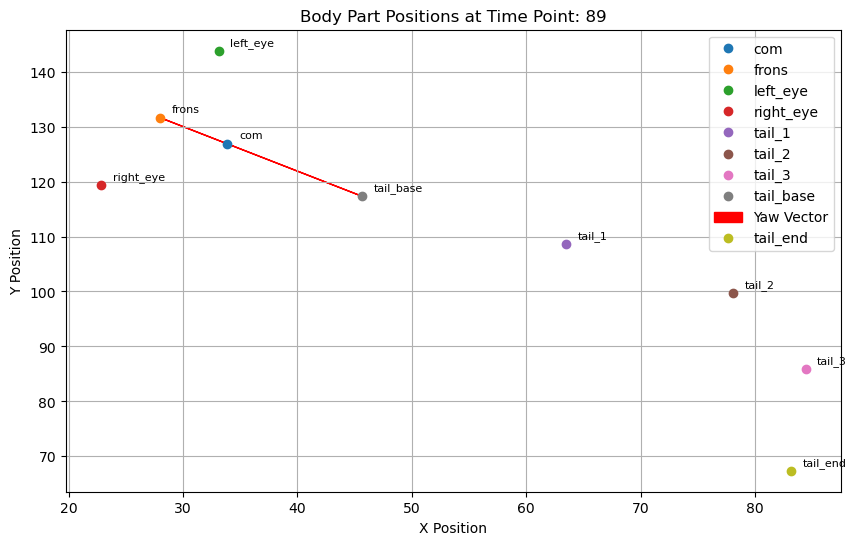

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame containing columns 'x', 'y', and 'yaw' with 'yaw_vector' as a sub-column
# Example DataFrame creation (replace this with your actual DataFrame)


idx_to_visualise = 89
# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
plt.figure(figsize=(10, 6))  # Set plot size

# Loop through each body part
for bodypart in bodyparts:
    if bodypart == 'yaw':
        continue
    # Select data for this body part (all rows)
    bodypart_data = data.loc[idx_to_visualise, bodypart]  # Select specific level and column

    # Extract x and y data
    x_position = bodypart_data['x']
    y_position = bodypart_data['y']
    print(str(bodypart) + " Y: " + str(y_position) + " X: " + str(x_position))
    # Plot the points with labels
    plt.plot(x_position, y_position, 'o', label=bodypart)  # Plot and label
    plt.text(x_position + 1, y_position + 1, bodypart, fontsize=8)  # Add text label

    # Plot the yaw vector starting from tail_base
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data
        yaw_vector = data.loc[idx_to_visualise, ('yaw', 'yaw_vector')]
        
        # Unpack x and y components of yaw vector
        yaw_x, yaw_y = yaw_vector
        print("Yaw: "+ " Y: " + str(yaw_y) + " X: " + str(yaw_x))
        # Plot the yaw vector starting from tail_base point
        plt.arrow(x_position, y_position, yaw_x, yaw_y, color='r', label='Yaw Vector')

# Configure plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Body Part Positions at Time Point: " + str(idx_to_visualise))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [210]:
data.iloc[89]

left_eye   x                                             33.145973
           y                                            143.817474
           likelihood                                     0.999993
right_eye  x                                              22.84366
           y                                            119.458023
           likelihood                                     0.999999
tail_base  x                                             45.663185
           y                                            117.311279
           likelihood                                     0.999992
tail_1     x                                             63.504025
           y                                            108.586494
           likelihood                                     0.999957
tail_2     x                                             78.064407
           y                                             99.746078
           likelihood                                     0.99